In [30]:
import numpy as np
import pandas as pd
import re, nltk, spacy, gensim
from nltk.corpus import stopwords

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint

# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline

In [127]:
data = pd.read_csv('Data/posts.csv', encoding='utf-8',error_bad_lines=False);
docs=data['body'].drop_duplicates().values.tolist()
data[:10]

,Unnamed: 0,id,title,body,post_id
0,0,1,ابنتي يالسبيعي,\n\nابنتي يالسبيعيابنتي بدأت تكتشف غريزتها ال...,31172
1,1,2,لماذا أنا طيب ؟,\n\nلماذا أنا طيب ؟لماذا أنا طيب ؟ لماذا إذا أ...,31196
2,2,3,خمسه وعشرون سنه من المعاناه فهل من منقذ قبل فو...,\n\nخمسه وعشرون سنه من المعاناه فهل من منقذ قب...,31214
3,3,4,00فن الإنصات00,\n\n00فن الإنصات00كيف أتعلم فن الانصات\n\r\nرأ...,31225
4,4,5,البكاء .... يادكتور سبيعي,\n\nالبكاء .... يادكتور سبيعيالسلام عليكم ورحم...,31234
5,5,6,طائر يسجد لله,\n\nطائر يسجد للهطائر يسجد لله ((منقول))\n\r\n...,31235
6,6,7,معلومات خفيفة وغريبة نوعاً ما,\n\nمعلومات خفيفة وغريبة نوعاً مامعلومات خفيفة...,31236
7,7,8,فتاة يخرج أنفها المسك عند تغسيلها,\n\nفتاة يخرج أنفها المسك عند تغسيلهافتاة يخرج...,31237
8,8,9,الموسيقى ..اسمع وتمتع,\n\nالموسيقى ..اسمع وتمتعليش تبي تسمع نسيت أنه...,31252
9,9,10,عــلاج الحســد000لايفوتكم 000مهم جدا000,\n\nعــلاج الحســد000لايفوتكم 000مهم جدا000بسم...,31257


In [128]:
STOPWORDS = set(stopwords.words('english')+stopwords.words('arabic'))

tobespace_re = r'[\/\\(){}\[\]\|\"\'،…—.;,-=+$%^&*:÷×؛~٪؟?!_#@]'
arabic_diacritics = re.compile("""
                             ّ    | # Tashdid
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)

def normalize(text):
    text = re.sub("[إأآ]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("[ؤئ]", "ء", text)
    text = re.sub("هة", "ه", text)
    text = re.sub("[ة]", "ه", text)
    text = re.sub("گ", "ك", text)
    text = re.sub(arabic_diacritics, '', text)
    return text

def clean(text):
    text = re.sub(r'http\S+', '', text)    #لإزالة الروابط
    text = re.sub(r'\S+@\S+\s?', '', text)  #لإزالة البريد الإلكتروني  
    text = re.sub(r'@\S+', '', text)       #لإزالة المنشنات
    text = re.sub(r'pic.\S+', '', text)    #لإزالة الصور
#     stemmer = isri.ISRIStemmer()
#     text = " ".join(stemmer.stem(w) for w in text.split() if ( (w not in STOPWORDS) and (len(w)>3) ))
    text = " ".join(w for w in text.split() if ( (w not in STOPWORDS) and (len(w)>3) ))
    text = normalize(text)
    text = re.sub(r'(.)\1+', r'\1\1', text)         # إزالة الأحرف المكررة أكثر من مرتين
    text = re.sub(r'(.)(.)(\1\2)+', r'\1\2', text)  #إزالة ثنائية الأحرف المكررة
    text = re.sub(tobespace_re, ' ', text)          # الإستبدال بفراغ
    text = re.sub(r'\s+', ' ', text)                #إزالة الفراغات المكررة 
    text = text.lower()
#     clean = [w for w in text.split()]
    return text

In [129]:
cleaned_docs = [clean(doc) for doc in docs]

7. Create the Document-Word matrix

The LDA topic model algorithm requires a document word matrix as the main input.

You can create one using CountVectorizer. In the below code, I have configured the CountVectorizer to consider words that has occurred at least 10 times (min_df), remove built-in english stopwords, convert all words to lowercase, and a word can contain numbers and alphabets of at least length 3 in order to be qualified as a word.

So, to create the doc-word matrix, you need to first initialise the CountVectorizer class with the required configuration and then apply fit_transform to actually create the matrix.

Since most cells contain zeros, the result will be in the form of a sparse matrix to save memory.

If you want to materialize it in a 2D array format, call the todense() method of the sparse matrix like its done in the next step.

In [73]:
vectorizer = CountVectorizer(#ngram_range=(1,2),
                             min_df=10)

data_vectorized = vectorizer.fit_transform(cleaned_docs)

8. Check the Sparsicity

Sparsicity is nothing but the percentage of non-zero datapoints in the document-word matrix, that is data_vectorized.

Since most cells in this matrix will be zero, I am interested in knowing what percentage of cells contain non-zero values.

In [ ]:
# Materialize the sparse data
data_dense = data_vectorized.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsicity: -0.3%

9. Build LDA model with sklearn

Everything is ready to build a Latent Dirichlet Allocation (LDA) model. Let’s initialise one and call fit_transform() to build the LDA model.

For this example, I have set the n_topics as 20 based on prior knowledge about the dataset. Later we will find the optimal number using grid search.

In [41]:
# Build LDA Model
lda_model = LatentDirichletAllocation(n_components=20,           # Number of topics
                                      max_iter=10,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(data_vectorized)

print(lda_model)  # Model attributes

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=20, n_jobs=-1,
                          perp_tol=0.1, random_state=100, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,    
             evaluate_every=-1, learning_decay=0.7,   
             learning_method='online', learning_offset=10.0,   
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,    
             n_components=10, n_jobs=-1, n_topics=20, perp_tol=0.1,    
             random_state=100, topic_word_prior=None,   
             total_samples=1000000.0, verbose=0)   

10. Diagnose model performance with perplexity and log-likelihood

A model with higher log-likelihood and lower perplexity (exp(-1. * log-likelihood per word)) is considered to be good. Let’s check for our model.

In [42]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(data_vectorized))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(data_vectorized))

# See model parameters
pprint(lda_model.get_params())

Log Likelihood:  -16785441.244628094
Perplexity:  7151.39355975934
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 20,
 'n_jobs': -1,
 'perp_tol': 0.1,
 'random_state': 100,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


On a different note, perplexity might not be the best measure to evaluate topic models because it doesn’t consider the context and semantic associations between words. This can be captured using topic coherence measure.

11. How to GridSearch the best LDA model?

The most important tuning parameter for LDA models is n_components (number of topics). In addition, I am going to search learning_decay (which controls the learning rate) as well.

Besides these, other possible search params could be learning_offset (downweigh early iterations. Should be > 1) and max_iter. These could be worth experimenting if you have enough computing resources.

the grid search constructs multiple LDA models for all possible combinations of param values in the param_grid dict.

In [43]:
# Define Search Param
search_params = {'n_components': [5, 8, 10, 15, 20, 25], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(data_vectorized)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=LatentDirichletAllocation(batch_size=128,
                                                 doc_topic_prior=None,
                                                 evaluate_every=-1,
                                                 learning_decay=0.7,
                                                 learning_method='batch',
                                                 learning_offset=10.0,
                                                 max_doc_update_iter=100,
                                                 max_iter=10,
                                                 mean_change_tol=0.001,
                                                 n_components=10, n_jobs=None,
                                                 perp_tol=0.1,
                                                 random_state=None,
                                                 topic_word_prior=None,
                                   

GridSearchCV(cv=None, error_score='raise',   
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,   
             evaluate_every=-1, learning_decay=0.7, learning_method=None,   
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,   
             mean_change_tol=0.001, n_components=10, n_jobs=1,   
             n_topics=None, perp_tol=0.1, random_state=None,    
             topic_word_prior=None, total_samples=1000000.0, verbose=0),   
       fit_params=None, iid=True, n_jobs=1,   
       param_grid={'n_topics': [5, 8, 10, 15, 20, 25], 'learning_decay': [0.5, 0.7, 0.9]},   
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',   
       scoring=None, verbose=0)   

12. How to see the best topic model and its parameters?

In [44]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'learning_decay': 0.9, 'n_components': 5}
Best Log Likelihood Score:  -5748064.402447553
Model Perplexity:  6773.365855242588


13. Compare LDA Model Performance Scores

Plotting the log-likelihood scores against num_topics, clearly shows number of topics = 10 has better scores. And learning_decay of 0.7 outperforms both 0.5 and 0.9.

This makes me think, even though we know that the dataset has 20 distinct topics to start with, some topics could share common keywords. For example, ‘alt.atheism’ and ‘soc.religion.christian’ can have a lot of common words. Same with ‘rec.motorcycles’ and ‘rec.autos’, ‘comp.sys.ibm.pc.hardware’ and ‘comp.sys.mac.hardware’, you get the idea.

To tune this even further, you can do a finer grid search for number of topics between 10 and 15. But I am going to skip that for now.

So the bottom line is, a lower optimal number of distinct topics (even 10 topics) may be reasonable for this dataset. I don’t know that yet. But LDA says so. Let’s see.

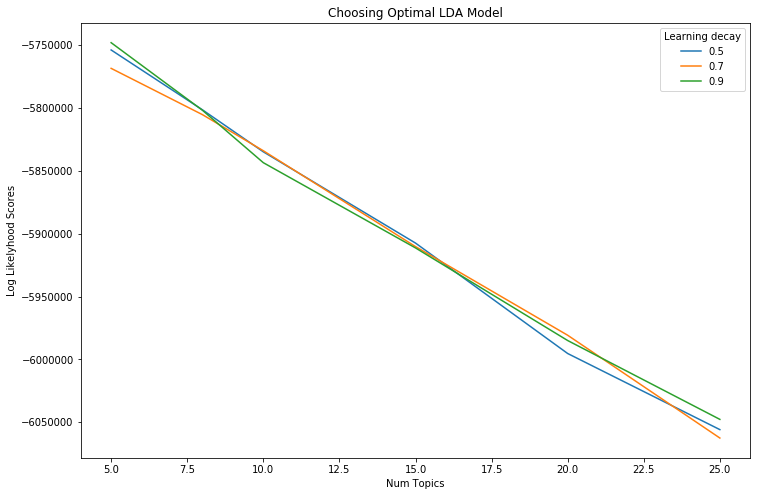

In [120]:
# Get Log Likelyhoods from Grid Search Output
n_topics = [5, 8, 10, 15, 20, 25]
results = pd.DataFrame(model.cv_results_)

mts=results['mean_test_score']
log_likelyhoods_5 = mts[:6]
log_likelyhoods_7 = mts[6:12]
log_likelyhoods_9 = mts[12:]

# Show graph
plt.figure(figsize=(12, 8))
plt.plot(n_topics, log_likelyhoods_5, label='0.5')
plt.plot(n_topics, log_likelyhoods_7, label='0.7')
plt.plot(n_topics, log_likelyhoods_9, label='0.9')
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()

14. How to see the dominant topic in each document?

To classify a document as belonging to a particular topic, a logical approach is to see which topic has the highest contribution to that document and assign it.

In the table below, I’ve greened out all major topics in a document and assigned the most dominant topic in its own column.

In [122]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(data_vectorized)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(docs))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,dominant_topic
Doc0,0.07,0.01,0.01,0.18,0.74,4
Doc1,0.66,0.17,0,0.07,0.1,0
Doc2,0,0.1,0,0.31,0.58,4
Doc3,0.15,0.07,0,0.67,0.11,3
Doc4,0.13,0,0,0,0.86,4
Doc5,0,0.61,0.27,0,0.12,1
Doc6,0.11,0.08,0.2,0.62,0,3
Doc7,0,0.21,0.79,0,0,2
Doc8,0.23,0.38,0.19,0,0.19,1
Doc9,0,0.75,0,0,0.24,1


15. Review topics distribution across documents

In [ ]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

16. How to visualize the LDA model with pyLDAvis?

The pyLDAvis offers the best visualization to view the topics-keywords distribution.

A good topic model will have non-overlapping, fairly big sized blobs for each topic. This seems to be the case here. So, we are good.

In [54]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, data_vectorized, vectorizer, mds='tsne')
panel

C:\ProgramData\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
4      132.981628 -144.236893       1        1  28.545210
1      -39.950676 -152.334320       2        1  23.601761
3      198.197876    9.348442       3        1  23.582996
0       83.978249  139.442566       4        1  13.833811
2      -27.386929   14.535013       5        1  10.436222, topic_info=      Category          Freq    Term         Total  loglift  logprob
6420   Default  43746.000000    الله  43746.000000  30.0000  30.0000
24694  Default   4513.000000    وسلم   4513.000000  29.0000  29.0000
6806   Default   3185.000000  المراه   3185.000000  28.0000  28.0000
11495  Default   3133.000000   تعالي   3133.000000  27.0000  27.0000
16123  Default   6579.000000   عليكم   6579.000000  26.0000  26.0000
...        ...           ...     ...           ...      ...      ...
11862   Topic5    421.877248    تقول   1588.051173   0.9343  -6.1482
7024    Topic5    879.656350  المصدر  14899.818948  -0.5697  -5.4134
21517   Topic5    862.816978  نفساني  15603.590058  -0.6352  -5.4327
2847    Topic5    408.045780    الام   1762.526014   0.7968  -6.1815
2548    Topic5    347.277256   الارض   1455.423958   0.8270  -6.3428

[452 rows x 6 columns], token_table=       Topic      Freq    Term
term                          
3          5  0.989173   allah
48         5  0.989397    know
52         5  0.989050    life
54         5  0.989510    like
66         5  0.989275    need
...      ...       ...     ...
27663      2  0.022191    يمكن
27663      3  0.573791    يمكن
27663      4  0.072384    يمكن
27663      5  0.073969    يمكن
27729      4  0.955614  ينتظرك

[1158 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 2, 4, 1, 3])

17. How to see the Topic’s keywords?

The weights of each keyword in each topic is contained in lda_model.components_ as a 2d array. The names of the keywords itself can be obtained from vectorizer object using get_feature_names().

Let’s use this info to construct a weight matrix for all keywords in each topic.

In [55]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(best_lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames

# View
df_topic_keywords.head()

,aa,al,align,allah,also,arab,arabia,arabic,aurorix,best,...,يومي,يوميا,يوميات,يومين,يوميه,يونس,يونيو,يووه,يياس,ييسر
Topic0,10.916225,0.880723,7.349556,0.200230,0.200000,0.200229,0.200008,0.202504,0.200002,0.200134,...,3.739760,0.492539,0.203905,0.205828,0.200697,0.200964,1.581385,0.201055,6.274209,0.206668
Topic1,0.202463,15.901111,2.590175,0.201149,0.201077,0.200558,1.400958,1.716943,0.200057,0.200409,...,26.665265,17.576326,0.200850,13.871351,0.203120,43.144940,0.203397,0.200925,9.189317,19.835229
Topic2,0.202367,4.671780,4.828725,59.198236,20.198687,9.583683,0.553415,16.282918,0.200002,15.198506,...,1.759620,63.251656,5.551595,53.002900,0.206251,0.204266,16.705718,15.695852,0.202730,0.201556
Topic3,0.201347,4.340512,9.283409,0.200267,0.200143,2.814787,2.510216,2.594426,0.200700,0.200632,...,31.269247,229.526768,4.287529,7.769381,23.154906,0.249624,1.264654,0.200038,2.407460,0.441119
Topic4,12.477598,0.205874,14.948135,0.200118,0.200092,0.200742,6.335403,0.203208,16.199239,0.200319,...,68.566108,175.152710,6.756122,185.150540,11.235026,0.200207,1.244846,7.702130,1.926284,21.315428


18. Get the top 15 keywords each topic

From the above output, I want to see the top 15 keywords that are representative of the topic.

The show_topics() defined below creates that.

In [56]:
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=15)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,المراه,نفساني,الحياه,المصدر,الحب,الرجل,عندما,الله,الناس,لماذا,تكون,كانت,نفسك,الانسان,السعاده
Topic 1,الله,وسلم,تعالي,رسول,المصدر,نفساني,فقال,الناس,اللهم,الصلاه,الجنه,القران,الدنيا,محمد,النبي
Topic 2,كانت,المصدر,نفساني,قالت,اللي,اليوم,انها,واحد,عليها,وكان,الشاب,البيت,وبعد,الفتاه,وقال
Topic 3,يكون,المصدر,نفساني,الانسان,الاخرين,تكون,النفسيه,الناس,الطفل,خلال,النفسي,يمكن,النفس,الله,ايضا
Topic 4,الله,نفساني,المصدر,عليكم,ورحمه,وانا,وبركاته,نفسي,انني,السلام,اريد,الان,المنتدي,والله,انها


19. How to predict the topics for a new piece of text?

Assuming that you have already built the topic model, you need to take the text through the same routine of transformations and before predicting the topic.

For our case, the order of transformations is:

sent_to_words() –> lemmatization() –> vectorizer.transform() –> best_lda_model.transform()

You need to apply these transformations in the same order. So to simplify it, let’s combine these steps into a predict_topic() function. 

In [64]:
# Define function to predict topic for a given text document.
#  nlp = spacy.load('en', disable=['parser', 'ner'])

def predict_topic(text):
    # Step 1: Clean with clean
    mytext_2 = [clean(text)]

    # Step 2: Vectorize transform
    mytext_3 = vectorizer.transform(mytext_2)

    # Step 3: LDA Transform
    topic_probability_scores = best_lda_model.transform(mytext_3)
    topic = df_topic_keywords.iloc[np.argmax(topic_probability_scores), :].values.tolist()
    return topic, topic_probability_scores

# Predict the topic
mytext = ["أعاني من الخوف و الوحدة "]
topic, prob_scores = predict_topic(text = mytext[0])
print(topic)

['الله', 'نفساني', 'المصدر', 'عليكم', 'ورحمه', 'وانا', 'وبركاته', 'نفسي', 'انني', 'السلام', 'اريد', 'الان', 'المنتدي', 'والله', 'انها']


20. How to cluster documents that share similar topics and plot?

You can use k-means clustering on the document-topic probabilioty matrix, which is nothing but lda_output object. Since our best model has 5 clusters, I’ve set n_clusters=5 in KMeans().

Alternately, you could avoid k-means and instead, assign the cluster as the topic column number with the highest probability score.

We now have the cluster number. But we also need the X and Y columns to draw the plot.

For the X and Y, you can use SVD on the lda_output object with n_components as 2. SVD ensures that these two columns captures the maximum possible amount of information from lda_output in the first 2 components. 

In [70]:
# Construct the k-means clusters
from sklearn.cluster import KMeans
clusters = KMeans(n_clusters=5, random_state=100).fit_predict(lda_output)

# Build the Singular Value Decomposition(SVD) model
svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_output_svd = svd_model.fit_transform(lda_output)

# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]

# Weights for the 15 columns of lda_output, for each component
print("Component's weights: \n", np.round(svd_model.components_, 2))

# Percentage of total information in 'lda_output' explained by the two components
print("Perc of Variance Explained: \n", np.round(svd_model.explained_variance_ratio_, 2))

Component's weights: 
 [[ 0.1   0.1   0.07  0.15  0.98]
 [ 0.33  0.82  0.16  0.41 -0.19]]
Perc of Variance Explained: 
 [0.3  0.23]


We have the X, Y and the cluster number for each document.

Let’s plot the document along the two SVD decomposed components. The color of points represents the cluster number (in this case) or topic number.

Text(0.5, 1.0, 'Segregation of Topic Clusters')

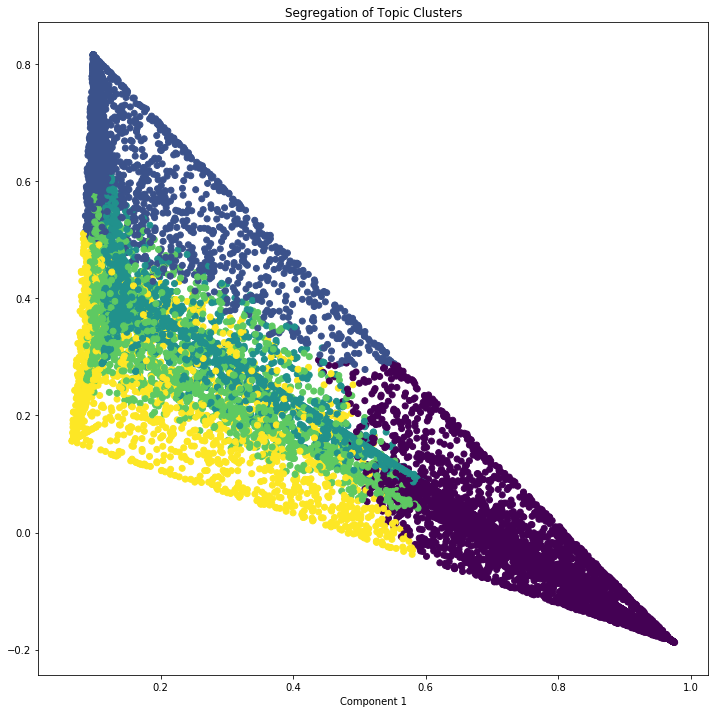

In [71]:
# Plot
plt.figure(figsize=(12, 12))
plt.scatter(x, y, c=clusters)
plt.xlabel('Component 2')
plt.xlabel('Component 1')
plt.title("Segregation of Topic Clusters", )

21. How to get similar documents for any given piece of text?

Once you know the probaility of topics for a given document (using predict_topic()), compute the euclidean distance with the probability scores of all other documents.

The most similar documents are the ones with the smallest distance.

In [124]:
from sklearn.metrics.pairwise import euclidean_distances

def similar_documents(text, doc_topic_probs, documents = docs, top_n=5, verbose=False):
    topic, x  = predict_topic(text)
    dists = euclidean_distances(x.reshape(1, -1), doc_topic_probs)[0]
    doc_ids = np.argsort(dists)[:top_n]
    if verbose:        
        print("Topic KeyWords: ", topic)
        print("Topic Prob Scores of text: ", np.round(x, 1))
        print("Most Similar Doc's Probs:  ", np.round(doc_topic_probs[doc_ids], 1))
    return doc_ids, np.take(documents, doc_ids)

In [143]:
# Get similar documents
mytext = " أولادي بعيدين عني أنا أشعر بالوحدة"
doc_ids, simdocuments = similar_documents(text=mytext, doc_topic_probs=lda_output, documents = docs, top_n=1, verbose=True)
print('\n', simdocuments)

Topic KeyWords:  ['الله', 'نفساني', 'المصدر', 'عليكم', 'ورحمه', 'وانا', 'وبركاته', 'نفسي', 'انني', 'السلام', 'اريد', 'الان', 'المنتدي', 'والله', 'انها']
Topic Prob Scores of text:  [[0.  0.  0.  0.  0.8]]
Most Similar Doc's Probs:   [[0.  0.  0.  0.  0.8]]

 ['\n\nالعلاج بالطاقةما هي تجاربكم معه وهل هو مُجدي؟\r\n\t\n\n\n\n\n\nالمصدر: نفساني\n\n\n']
